<a href="https://colab.research.google.com/github/ganireddikumar/Assignment1/blob/main/extras/exercises/09_pytorch_model_deployment_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. PyTorch Model Deployment Exercises

Welcome to the 09. PyTorch Model Deployment exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/jOX5ZCkWO-0) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/).

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) > 1, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1540/1540), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 4393 (delta 1459), reused 1408 (delta 1401), pack-reused 2853 (from 1)
Receiving objects: 100% (4393/4393), 650.73 MiB | 13.37 MiB/s, done.
Resolving deltas: 100% (2661/2661), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Model Deployment: https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d9b0bf43bd0>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

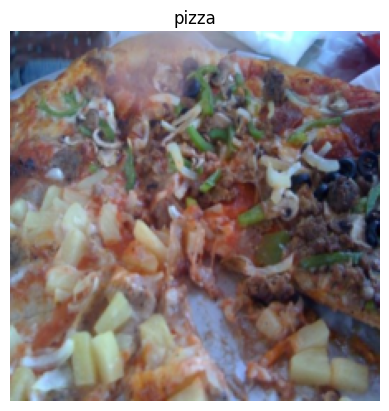

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## Exercise 1. Make and time predictions with both feature extractor models on the test dataset using the GPU (`device="cuda"`).

* Compare the model's prediction times on GPU vs CPU - does this close the gap between them? As in, does making predictions on the GPU make the ViT feature extractor prediction times closer to the EffNetB2 feature extractor prediction times?
* You'll find code to do these steps in [section 5. Making predictions with our trained models and timing them](https://www.learnpytorch.io/09_pytorch_model_deployment/#5-making-predictions-with-our-trained-models-and-timing-them) and [section 6. Comparing model results, prediction times and size](https://www.learnpytorch.io/09_pytorch_model_deployment/#6-comparing-model-results-prediction-times-and-size).

In [10]:
# TODO: your code
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3,inplace=True),
      nn.Linear(in_features=1408,out_features=num_classes)
  )

  return model,transforms

In [11]:
effnetb2, effnetb2_transforms = create_effnetb2_model()
effnetb2_transforms

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 132MB/s]


ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [12]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [13]:
from going_modular.going_modular import data_setup

BATCH_SIZE =32
train_dataloader_effnetb2, test_dataloader_effnetb2,class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=BATCH_SIZE)
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [14]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=effnetb2.parameters(),lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

effnetb2_results = engine.train(model =effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader =test_dataloader_effnetb2,
                                epochs=10,
                                optimizer = optimizer,
                                loss_fn = loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


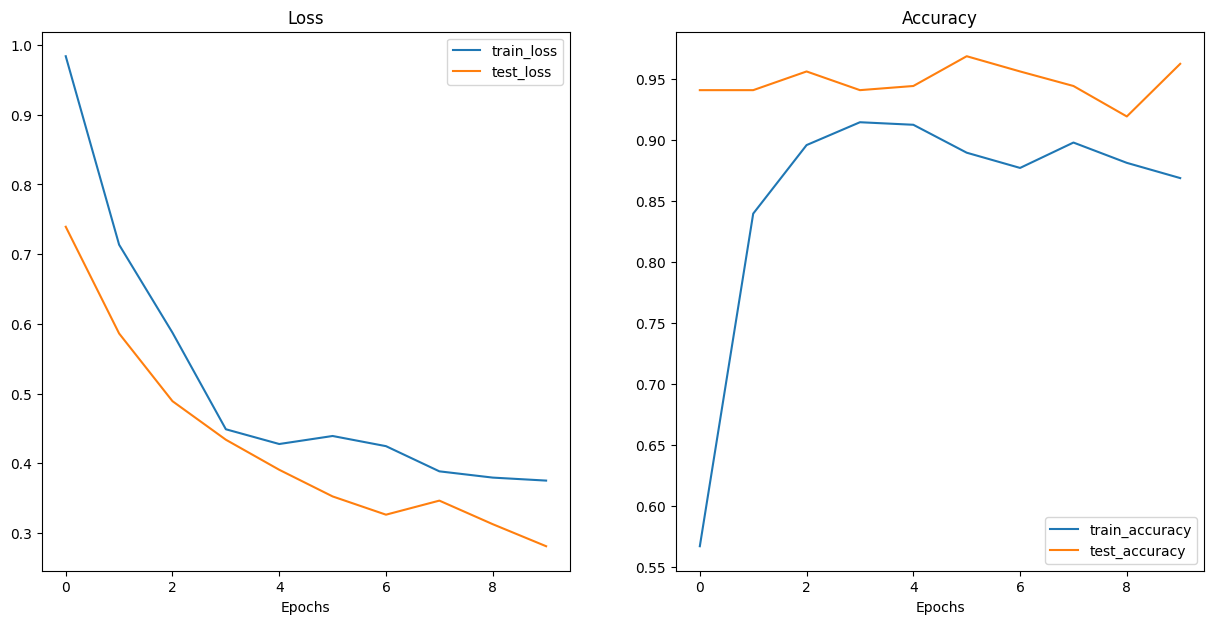

In [15]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [16]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.heads= nn.Sequential(nn.Linear(in_features=768,
                                       out_features=num_classes))

  return model,transforms

In [17]:
vit, vit_transforms = create_vit_model()
# vit
vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 178MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [18]:
from going_modular.going_modular import data_setup

BATCH_SIZE=32

train_dataloader_vit,test_dataloader_vit,class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=vit_transforms,
                                                                                                 batch_size=BATCH_SIZE)
len(train_dataloader_vit),len(test_dataloader_vit),class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [19]:
from going_modular.going_modular import engine
optimizer = torch.optim.Adam(params=vit.parameters(),lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

vit_results=engine.train(model=vit,
                         train_dataloader=train_dataloader_vit,
                         test_dataloader = test_dataloader_vit,
                         epochs=10,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


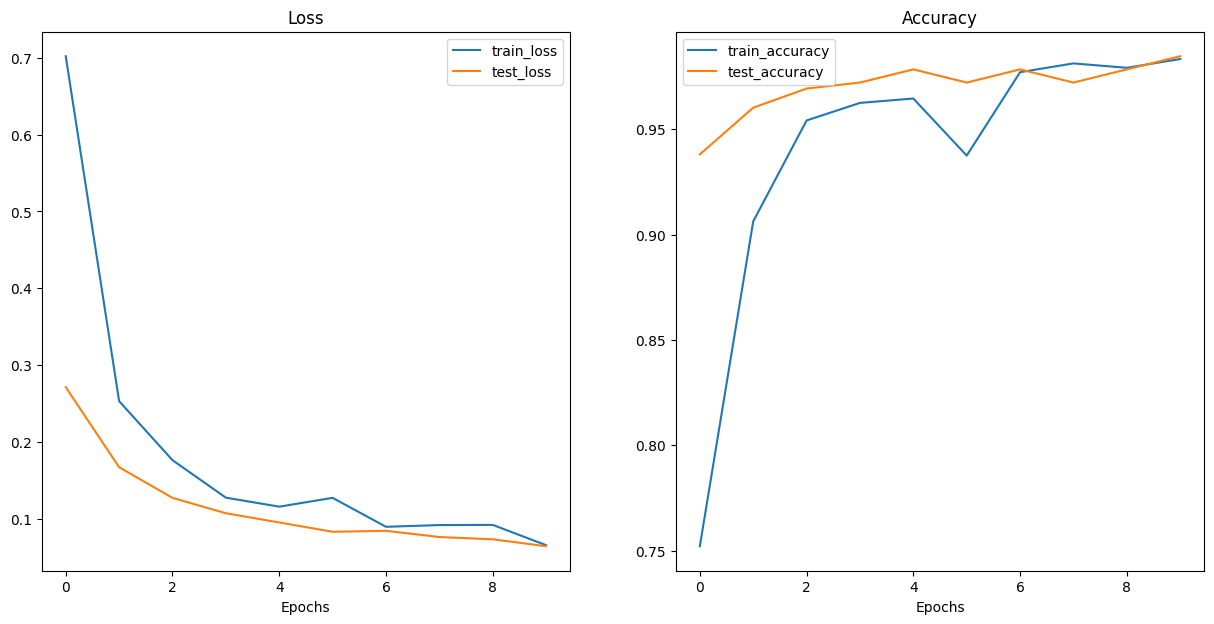

In [20]:
plot_loss_curves(vit_results)

In [21]:
from pathlib import Path
test_image_paths = list(Path(test_dir).glob("*/*.jpg"))
len(test_image_paths)

150

In [22]:
test_image_paths[:5]

[PosixPath('data/pizza_steak_sushi/test/sushi/705150.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/593071.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/780283.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/715227.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/3834718.jpg')]

In [23]:
class_names

['pizza', 'steak', 'sushi']

In [24]:
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

In [25]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List,Dict

def pred_and_store(paths:List[pathlib.Path],
                   model: torch.nn.Module,
                   transform:torchvision.transforms,
                   class_names:List[str],
                   device:str="cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

  pred_list = []

  for path in tqdm(paths):
    pred_dict = {}

    pred_dict["image_path"] =path
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    start_time = timer()

    img = Image.open(path)

    transformed_image = transform(img).unsqueeze(0).to(device)

    model = model.to(device)
    model.eval()

    with torch.inference_mode():
      pred_logit = model(transformed_image) # perform inference on target sample
      pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
      pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
      pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

      # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
      pred_dict["pred_prob"] = round(pred_prob.max().cpu().item(), 4)
      pred_dict["pred_class"] = pred_class

      # 12. End the timer and calculate time per pred
      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time-start_time, 4)

    # 13. Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # 14. Add the dictionary to the list of preds
    pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
  return pred_list




In [26]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [27]:
effnetb2_preds_on_cpu = pred_and_store(paths=test_image_paths,
                                       model=effnetb2,
                                       transform=effnetb2_transforms,
                                       class_names=class_names,
                                       device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [28]:
vit_preds_on_cpu = pred_and_store(paths=test_image_paths,
                                       model=vit,
                                       transform=vit_transforms,
                                       class_names=class_names,
                                       device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [29]:
effnetb2_preds_on_gpu = pred_and_store(paths=test_image_paths,
                                       model=effnetb2,
                                       transform=effnetb2_transforms,
                                       class_names=class_names,
                                       device="cuda")

vit_preds_on_gpu = pred_and_store(paths=test_image_paths,
                                  model=vit,
                                  transform=vit_transforms,
                                  class_names=class_names,
                                  device="cuda")

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

In [30]:
import pandas as pd

def get_mean_pred_time(input):
  df = pd.DataFrame(input)
  return df.time_for_pred.mean()

effnetb2_cpu_pred_time = get_mean_pred_time(effnetb2_preds_on_cpu)
effnetb2_cpu_pred_time

0.10657933333333333

In [31]:
effnetb2_gpu_pred_time = get_mean_pred_time(effnetb2_preds_on_gpu)
vit_cpu_pred_time = get_mean_pred_time(vit_preds_on_cpu)
vit_gpu_pred_time = get_mean_pred_time(vit_preds_on_gpu)

pred_times = {"effnetb2_cpu": effnetb2_cpu_pred_time,
              "vit_cpu": vit_cpu_pred_time,
              "effnetb2_gpu": effnetb2_gpu_pred_time,
              "vit_gpu": vit_gpu_pred_time}

pred_times_df = pd.DataFrame(pred_times, index=[0])
pred_times_df

,effnetb2_cpu,vit_cpu,effnetb2_gpu,vit_gpu
0,0.106579,0.557222,0.025853,0.019785


## Exercise 2. The ViT feature extractor seems to have more learning capacity (due to more parameters) than EffNetB2, how does it go on the larger 20% split of the entire Food101 dataset?

* Train a ViT feature extractor on the 20% Food101 dataset for 5 epochs, just like we did with EffNetB2 in section [10. Creating FoodVision Big](https://www.learnpytorch.io/09_pytorch_model_deployment/#10-creating-foodvision-big).

In [32]:
# TODO: your code
vit_food101_20_percent, vit_transforms = create_vit_model(num_classes=101)

from torchinfo import summary
summary(vit_food101_20_percent,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 101]             768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [33]:
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    vit_transforms
])

food101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
)

In [34]:
from torchvision import datasets

from pathlib import Path
data_dir = Path("data")

train_data = datasets.Food101(root=data_dir,
                              split="train",
                              transform = food101_train_transforms,
                              download=True)
test_data = datasets.Food101(root=data_dir,
                              split="test",
                              transform = vit_transforms,
                              download=True)

100%|██████████| 5.00G/5.00G [04:05<00:00, 20.4MB/s]


Extracting data/food-101.tar.gz to data


In [35]:
food101_class_names = train_data.classes

In [36]:
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [37]:
def split_dataset(dataset:torchvision.datasets,split_size:float=0.2,seed:int=42):

  length_1 = int(len(dataset) * split_size)
  length_2 = len(dataset)-length_1

  print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

  random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed)) # set the random seed for reproducible splits
  return random_split_1, random_split_2

In [38]:
train_data_food101_20_percent, _= split_dataset(dataset=train_data,
                                                split_size=0.2)
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

In [39]:
from torch.utils.data import DataLoader

BATCH_SIZE=32
NUM_WORKERS=2

train_dataloader_food101 = DataLoader(train_data_food101_20_percent,
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      num_workers=NUM_WORKERS)

test_dataloader_food101 = DataLoader(test_data_food101_20_percent,
                                      batch_size=BATCH_SIZE,
                                      shuffle=False,
                                      num_workers=NUM_WORKERS)

len(train_dataloader_food101), len(test_dataloader_food101)

(474, 158)

In [ ]:
loss_fn= torch.nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.Adam(params=vit_food101_20_percent.parameters(),
                             lr=1e-3)

set_seeds()

vit_food101_20_percent_results = engine.train(model=vit_food101_20_percent,
                                              train_dataloader=train_dataloader_food101,
                                              test_dataloader=test_dataloader_food101,
                                              epochs=5,
                                              optimizer=optimizer,
                                              loss_fn=loss_fn,
                                              device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

## Exercise 3. Make predictions across the 20% Food101 test dataset with the ViT feature extractor from exercise 2 and find the "most wrong" predictions
* The predictions will be the ones with the highest prediction probability but with the wrong predicted label.
* Write a sentence or two about why you think the model got these predictions wrong.

In [ ]:
# TODO: your code
test_dataloader_food101_batch_size_1 =DataLoader(test_data_food101_20_percent,
                                                 batch_size=1,
                                                 shuffle=False,
                                                 num_workers =NUM_WORKERS)

vit_food101_20_percent = vit_food101_20_percent.to(device)
vit_food101_20_percent.eval()

vit_food101_pred_list = []
for X,y in tqdm(test_dataloader_food101_batch_size_1):
  X,y = X.to(device),y.to(device)

  pred_dict ={}

  with torch.inference_mode():
    pred_probs = torch.softmax(vit_food101_20_percent(X), dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)
    pred_dict["pred_prob"] = torch.max(pred_probs).cpu().numpy()
    pred_dict["pred_label"] = pred_labels.cpu().numpy()[0]
    pred_dict["label"] = y.cpu().numpy()[0]

  vit_food101_pred_list.append(pred_dict)


In [ ]:
food101_class_names[:5]

In [ ]:
pred_df_20_percent = pd.DataFrame(vit_food101_pred_list)

pred_df_20_percent["is_correct"] =pred_df_20_percent["pred_label"] == pred_df_20_percent["label"]

# Create class name columns (e.g. pred_label=72 -> pred_class="pancakes")
pred_df_20_percent["pred_class"] = pred_df_20_percent["pred_label"].apply(lambda x: food101_class_names[x])
pred_df_20_percent["label_class"] = pred_df_20_percent["label"].apply(lambda x: food101_class_names[x])

In [ ]:
pred_df_20_percent[pred_df_20_percent["is_correct"] == False].sort_values("pred_prob", ascending=False)[:10]

## Exercise 4. Evaluate the ViT feature extractor across the whole Food101 test dataset rather than just the 20% version, how does it perform?
* Does it beat the original Food101 paper's best result of 56.4% accuracy?

In [ ]:
# TODO: your code
len(test_data)

In [ ]:
test_dataloader_food101_all_data_batch_size_1 = DataLoader(test_data,
                                                           batch_size=1,
                                                           shuffle=False,
                                                           num_workers=NUM_WORKERS)
len(test_dataloader_food101_all_data_batch_size_1)

In [ ]:
vit_food101_20_percent = vit_food101_20_percent.to(device)
vit_food101_20_percent.eval()

vit_food101_all_test_data_pred_list =[]
for X,y in tqdm(test_dataloader_food101_all_data_batch_size_1):
  X,y = X.to(device),y.to(device)

  pred_dict={}

  with torch.inference_mode():
    pred_probs = torch.softmax(vit_food101_20_percent(X), dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)
    pred_dict["pred_prob"] = torch.max(pred_probs).cpu().numpy()
    pred_dict["pred_label"] = pred_labels.cpu().numpy()[0]
    pred_dict["label"] = y.cpu().numpy()[0]

  vit_food101_all_test_data_pred_list.append(pred_dict)


In [ ]:
food101_all_test_data_df = pd.DataFrame(vit_food101_all_test_data_pred_list)
food101_all_test_data_df["is_correct"] = food101_all_test_data_df["pred_label"] == food101_all_test_data_df["label"]
food101_all_test_data_df.is_correct.value_counts()

In [ ]:
print(f"Accuracy of ViT model on all of Food101 test data: {food101_all_test_data_df.is_correct.value_counts()[1] / len(food101_all_test_data_df)}")

## Exercise 5. Head to [Paperswithcode.com](https://paperswithcode.com/) and find the current best performing model on the Food101 dataset.
* What model architecture does it use?

In [ ]:
# TODO: your answer to the above

## Exercise 6. Write down 1-3 potential failure points of our deployed FoodVision models and what some potential solutions might be.
* For example, what happens if someone was to upload a photo that wasn't of food to our FoodVision Mini model?

In [ ]:
# TODO: your answer to the above

## Exercise 7. Pick any dataset from [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) and train a feature extractor model on it using a model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) (you could use one of the model's we've already created, e.g. EffNetB2 or ViT) for 5 epochs and then deploy your model as a Gradio app to Hugging Face Spaces.
* You may want to pick smaller dataset/make a smaller split of it so training doesn't take too long.
* I'd love to see your deployed models! So be sure to share them in Discord or on the [course GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions).

In [ ]:
# TODO: your code